In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

import matplotlib.pyplot as plt

src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

## We will run various experiments to analyse the selection of heads.

### The stability of the head selection.

We wish to see if the same heads are consistently chosen and equally weighted.
- The radius of each set has is deterministic hence the instability of the process is only introduced by the random choice of which head to use.

## Comparing set vs pinball on Improved Implementation.

In [345]:
class set_safe_AwACI(AdaptiveCP):
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set) / optimal_set
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * val
    
    def set_loss_vectorize(self):
         return np.vectorize(self.set_loss)
    
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
        xpred, y = timeseries_data
        alpha_t_list = [self.coverage_target]

        All_scores = self.score_function(xpred, y)

        err_t_list = []
        conformal_sets_list = []
        
        for i in range(start_point, len(All_scores)):
            Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
            conformal_sets_list.append(Coverage_t)

            # We calculate the optimal B_t.

            yield Coverage_t

            error_t = AdaptiveCP.err_t(y[i], Coverage_t)
            err_t_list.append(error_t)

            alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
            alpha_t_list.append(alpha_t)

        return False
    
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-2, 0.05), gamma: float = 0.05, title: str = None):
        
        xpred, y = timeseries_data

        chosen_interval_index = []
        err_t_list = []
        conformal_sets_list = []
        optimal_radius_list = []
        chosen_radius_list = []

        radii_list = []
        all_interval_weights = []



        Set_loss = self.set_loss_vectorize()

        # Scale parameters, havent looked into scaling them best.
        sigma = nu_sigma[1]
        nu = nu_sigma[0] 

        if interval_candidates is None:
            interval_candidates = np.array(range(50, 550, 100))

        # To sync all of the heads we need to start at the max of all the candidates.
        start_point = max(interval_candidates) + 1
        i_count = start_point

        # Create the head and intitialse the weights.
        ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
        interval_weights = np.ones(len(interval_candidates))
        culmative_loss = np.zeros(len(interval_candidates))
        
        # Continues calculating intervals until one of the heads stops.
        none_terminated = True

        while none_terminated: 
            head_sets = [] # Will contain the result from each head.
                
            try:
                # Create a list of the coverages for the different heads.
                for head in ACI_heads:
                        head_sets.append(next(head))
            
            except StopIteration: # One head is terminated.
                none_terminated = False
                break # You could but the return statement here

            # Choosing which head to use.
            try:
                chosen_set = random.choices(head_sets, weights=interval_weights, k=1)[0] # Using random module as numpy can not deal with tuples.
            except ValueError:
                print(all_interval_weights[-5:])
                raise ValueError('Interval probabilities are not normalised correctly.')
            
            conformal_sets_list.append(chosen_set)
            chosen_interval_index.append(head_sets.index(chosen_set))

             # TIME FRONTIER -------------

            # Seeing whether result lies within the set.
            err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

            # Computing the conformal set radi. 
            optimal_set_radius = abs(y[i_count] - y[i_count-1]) ### Added abs as this shoudl always be positive. however still has seemed to change anything
            
            head_set_radius = list(map(lambda Cset: (Cset[1] - Cset[0])/2, head_sets)) #(chosen_set[1] - chosen_set[0])/2
            head_set_radius = np.array(head_set_radius)
            
            # Calculating the loss.
            culmative_loss += Set_loss(optimal_set_radius, head_set_radius)

            # Updating the weights.
            new_weights = interval_weights * np.exp(-1 * nu * culmative_loss) # log space
            final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma) # mean
            
            interval_weights = final_weights/sum(final_weights)


            # Incrementing the i-count
            i_count+=1

            # Appending the results to the lists.
            err_t_list.append(err_true)
            chosen_radius_list.append((chosen_set[1] - chosen_set[0]/2)) 
            optimal_radius_list.append(optimal_set_radius)
            radii_list.append(head_set_radius)
            all_interval_weights.append(interval_weights)

        # Calculating different averages
        realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
        average_prediction_interval = np.mean([abs(x[1] - x[0])/2 for x in conformal_sets_list])

        return {
                'model': title if title is not None else 'safe AwACI',
                'coverage_target': self.coverage_target,
                'interval_candidates': interval_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'optimal_set_radius': optimal_radius_list, 
                'chosen_set_radius': chosen_radius_list,
                'radii_list': radii_list,
                'all_weights': all_interval_weights,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'chosen_interval_index': chosen_interval_index,
                'start_point': start_point,
                'interval_size': 50
            }


In [247]:
class pinball_safe_AwACI(AdaptiveCP):
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
            xpred, y = timeseries_data
            alpha_t_list = [self.coverage_target]

            All_scores = self.score_function(xpred, y)

            err_t_list = []
            conformal_sets_list = []

            pinball_loss = self.vectorize_l()
            
            for i in range(start_point, len(All_scores)):
                Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
                conformal_sets_list.append(Coverage_t)

                # Finding B_t
                low, high = 0, 999 
                possibilities = np.linspace(0, 1, 1000) # as 1 - 

                B_t = 1
                while low <= high:
                    mid = (high + low) // 2
                    possi = possibilities[mid]
                    Cpossi = self.C_t(possi, All_scores, xpred[i], i, custom_interval)

                    if Cpossi[0] < y[i] < Cpossi[1]:
                        B_t = possi
                        low = mid + 1
                    else:
                        high = mid - 1

                yield Coverage_t, pinball_loss(B_t, alpha_t_list[-1])

                error_t = AdaptiveCP.err_t(y[i], Coverage_t)
                err_t_list.append(error_t)

                alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
                alpha_t_list.append(alpha_t)

            return False
        
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10*10**-1, 0.05), gamma: float = 0.05, title: str = None):
            
            _, y = timeseries_data

            chosen_interval_index = []
            err_t_list = []
            conformal_sets_list = []
            optimal_radius_list = []
            chosen_radius_list = []
            all_interval_weights = []
            radii_list = []

            # Scale parameters, havent looked into scaling them best.
            sigma = nu_sigma[1]
            nu = nu_sigma[0] 

            if interval_candidates is None:
                interval_candidates = np.array(range(50, 550, 100))

            # To sync all of the heads we need to start at the max of all the candidates.
            start_point = max(interval_candidates) + 1
            i_count = start_point

            # Create the head and intitialse the weights.
            ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
            interval_weights = np.ones(len(interval_candidates))
            culmative_loss = np.zeros(len(interval_candidates))
            
            # Continues calculating intervals until one of the heads stops.
            none_terminated = True

            while none_terminated: 
                head_sets = [] # Will contain the result from each head.
                pinball_loss_list = [] # Will contain the B_t values for each head.
                
                # Create the mass distribution for each head

                try:
                    # Create a list of the coverages for the different heads.
                    for head in ACI_heads:
                            coverage, loss = next(head)
                            
                            head_sets.append(coverage)
                            pinball_loss_list.append(loss)

                except StopIteration: # One head is terminated.
                    none_terminated = False
                    break # You could but the return statement here

                # Choosing which head to use.
                chosen_set = random.choices(head_sets, weights=interval_weights, k=1)[0] # Using random module as numpy can not deal with tuples.

                # TIME FRONTIER -------------

                # Seeing whether result lies within the set.
                err_true = AdaptiveCP.err_t(y[i_count], chosen_set)

                # Calculating the loss.
                culmative_loss += np.array(pinball_loss_list)

                # Updating the weights.
                new_weights = interval_weights * np.exp(-1 * nu * culmative_loss) # log space
                final_weights = new_weights*(1-sigma) + (new_weights.mean() *sigma) # mean

                interval_weights = final_weights/sum(final_weights)


                # Incrementing the i-count
                i_count+=1

                err_t_list.append(err_true)
                conformal_sets_list.append(chosen_set)
                chosen_interval_index.append(head_sets.index(chosen_set))
                radii_list.append([(h[1]-h[0])/2 for h in head_sets])
                all_interval_weights.append(interval_weights)
                
            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
            average_prediction_interval = np.mean([abs(x[1] - x[0])/2 for x in conformal_sets_list])

            return {
                    'model': title if title is not None else 'pinball AwACI',
                    'coverage_target': self.coverage_target,
                    'interval_candidates': interval_candidates,
                    'realised_interval_coverage': realised_interval_coverage,
                    'average_prediction_interval': average_prediction_interval,
                    'optimal_set_radius': optimal_radius_list, 
                    'chosen_set_radius': chosen_radius_list,
                    'conformal_sets': conformal_sets_list,
                    'error_t_list': err_t_list,
                    'radii_list': chosen_interval_index,
                    'start_point': start_point,
                    'interval_size': 50,
                    'radii_list': radii_list,
                    'all_weights': all_interval_weights
                }

In [87]:
# No shift data
no_shift_data = ACP_data.no_shift(seq_length=2000)

In [88]:
# Function to calculat the variances of the different heads.
def head_stability(data, method, times):
    all_weights = [method(data)['all_weights'] for i in range(times)]
    dstack = np.dstack(all_weights)

    mean_in_depth = dstack.mean(axis=2)
    variance_in_depth = dstack.var(axis=2)

    mean_in_head = mean_in_depth.mean(axis=0)
    mean_variance_in_head = variance_in_depth.mean(axis=0)

    return mean_in_head, mean_variance_in_head

def plot_stability(result):
    plt.pie(result[0], labels=[str(x) for x in range(50, 550, 100)], autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.show()
    

In [89]:
pin_no_shift_stability = head_stability(no_shift_data[0], pinball_safe_AwACI().AwACI, 10)

KeyboardInterrupt: 

In [ ]:
no_shift_stability = head_stability(no_shift_data[0], set_safe_AwACI().AwACI, 10)

Stability seems to be very good on no_shift_data.

In [ ]:
random_shift_data = ACP_data.random_shift(seq_range=(3000,3001))

In [ ]:
pin_random_shift_stability = head_stability(random_shift_data[0], pinball_safe_AwACI().AwACI, 10)

In [ ]:
set_random_shift_stability = head_stability(random_shift_data[0], set_safe_AwACI().AwACI, 10)

In [ ]:
print('random, pin', pin_random_shift_stability[1])
print('random, set', set_random_shift_stability[1])

random, pin [2.99807376e-34 3.01620727e-34 2.81371640e-34 2.84091667e-34
 2.88927270e-34]
random, set [1.52647326e-36 4.61446846e-33 2.95014274e-33 8.25216403e-36
 1.19892138e-33]


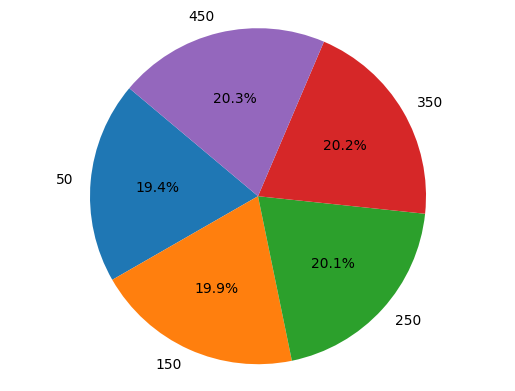

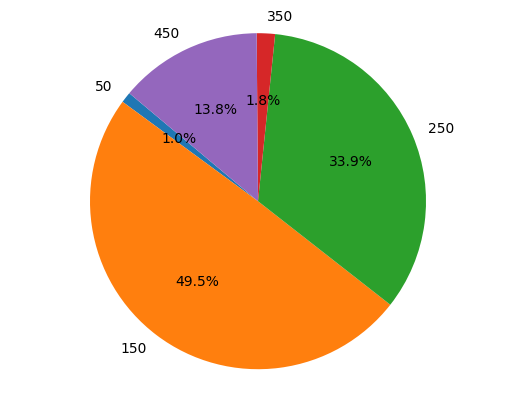

In [ ]:
plot_stability(pin_random_shift_stability)
plot_stability(set_random_shift_stability)


## Checking too see if the correct head it chosen.

First test, if the data is not shifting what does it choose. Hypothesis it should choose the largest head, as this should be the most performant.

In [90]:
def head_choice_vs_best(data, method, times):
    all_results = [method(data) for i in range(times)]
    all_weights = [x['all_weights'] for x in all_results]
    all_radii = [x['radii_list'] for x in all_results]

    len_labels = [str(x) for x in all_results[0]['interval_candidates']]

    weight_dstack = np.dstack(all_weights)
    mean_weight = weight_dstack.mean(axis=2).mean(axis=0)

    radii_dstack = np.dstack(all_radii)
    mean_radii = radii_dstack.mean(axis=2).mean(axis=0)
    
    average_prediction_interval = np.mean([x['average_prediction_interval'] for x in all_results])

    plt.pie(mean_weight, labels=len_labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.show()
    
    plt.bar(len_labels + ['method'] , np.append(mean_radii, average_prediction_interval))
    plt.show()

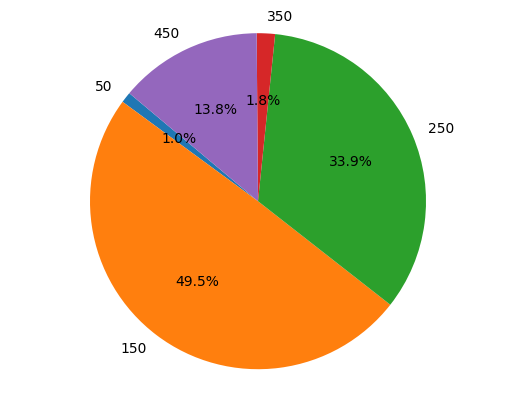

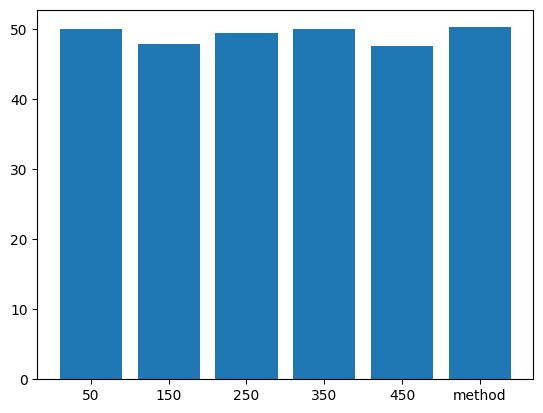

In [91]:
head_choice_vs_best(random_shift_data[0], set_safe_AwACI().AwACI, 1)

Well set loss chooses the head with the least width with greatest weight, but intrestingly none of the heads seem majorly better.

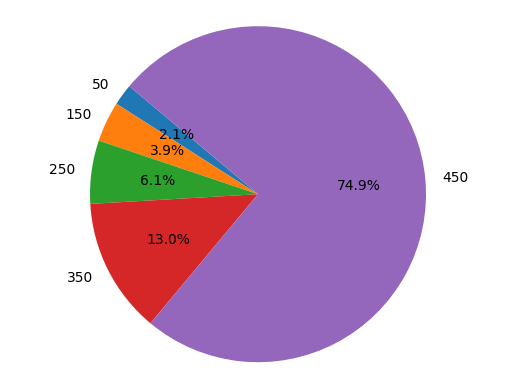

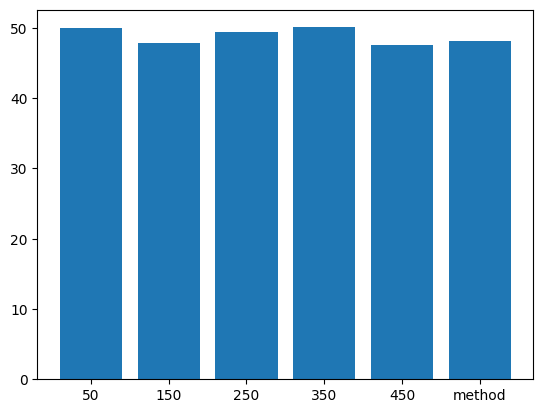

In [92]:
head_choice_vs_best(random_shift_data[0], pinball_safe_AwACI().AwACI, 1)

Pinball performing very well, with small mu 0.5.

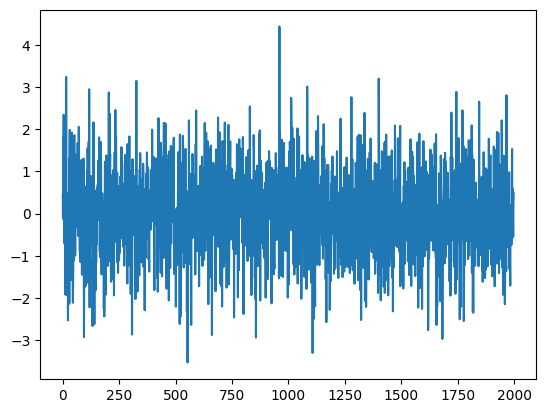

In [97]:
plt.plot(no_shift_data[0][0])
plt.show()

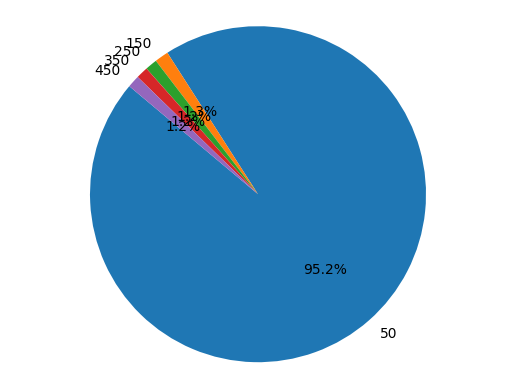

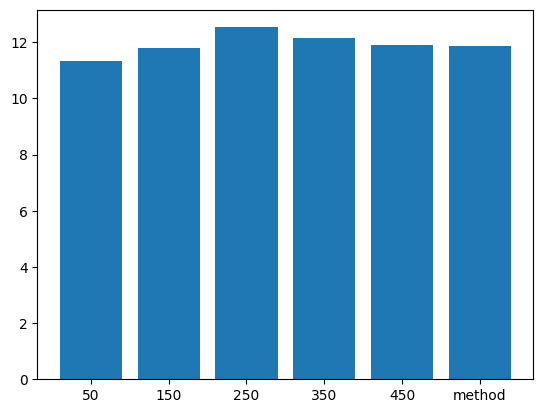

In [95]:
head_choice_vs_best(no_shift_data[0], set_safe_AwACI().AwACI, 10)

Chooses the head with the lowest loss, interestingly it is 150 again cant make sense of why this would be.

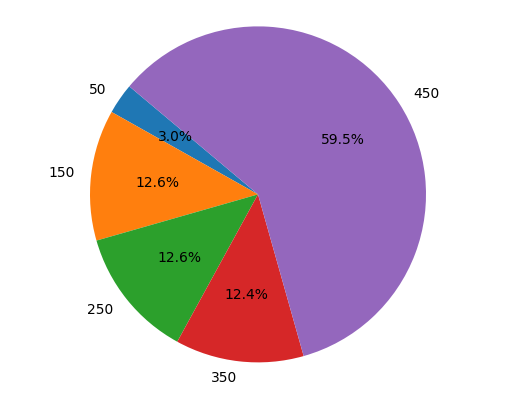

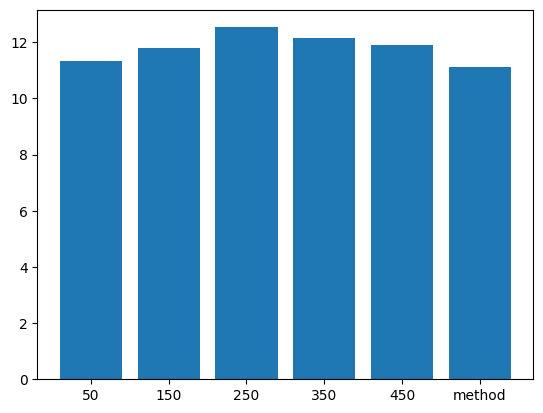

In [94]:
head_choice_vs_best(no_shift_data[0], pinball_safe_AwACI().AwACI, 1)

Performs how you would want it to, but doesnt reflect the one with the smallest radius

Seems to be more variance between the best head on the genration of the data than you would expect and it is not always the head with the largest lookback which performs best on the min.

In [98]:
# now we want to compare when there is a single shift in the data and obvious best choice.

Now you want to see prediction widths before and after the shift point.

In [239]:
length = 5000
shift_points = [0.5, 0.8]
shift_data = ACP_data.multiple_shift([(0,1), (3,5), (0,1)], shift_points=shift_points, seq_length=length)

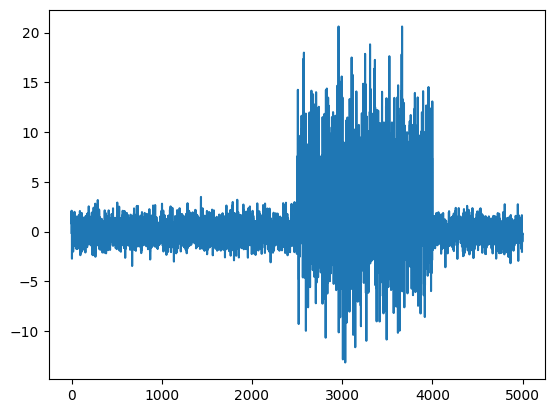

In [240]:
plt.plot(shift_data[0][0])
plt.show()

In [320]:
def analyse_shifts(data, method, candidates, shift_list, nu_sigma=(10**-2, 0.05)):
  
    result = method(data, interval_candidates=candidates, nu_sigma=nu_sigma)
    interval_candidates = result['interval_candidates']

    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, 1)
    plt.plot(data[0])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.title('Data with Shift Points')

    shift_list = [x - max(interval_candidates) for x in shift_list]
    plt.subplot(2, 2, 2)
    rel_weights = np.column_stack(result['all_weights'])
    for i, x in enumerate(rel_weights):
        plt.plot(x, label=interval_candidates[i])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.legend()
    plt.title('Weight Distribution')

    all_weights_splits = np.split(result['all_weights'], shift_list)
    all_radii_splits = np.split(result['radii_list'], shift_list)

    len_labels = [str(x) for x in interval_candidates]

    list_weight_dstack = [np.dstack(x) for x in all_weights_splits]
    list_mean_weight = [x.mean(axis=2).mean(axis=0) for x in list_weight_dstack]

    list_radii_dstack = [np.dstack(x) for x in all_radii_splits]
    list_mean_radii = [x.mean(axis=2).mean(axis=0) for x in list_radii_dstack]

    plt.subplot(2, 2, 3)
    plt.bar([str(x) for x in interval_candidates] + ['method'] , np.append(np.column_stack(result['radii_list']).mean(axis=1), result['average_prediction_interval']))
    plt.title('Radii Distribution')

    plt.tight_layout()
    plt.show()


    for i, (weight, radii) in enumerate(zip(list_mean_weight, list_mean_radii)):
        print('Section:', i, '-'*100)
        print(len(all_weights_splits[i]))
        
        # rel_weights =  np.column_stack(all_weights_splits[i])
        # for i, x in enumerate(rel_weights):
        #     plt.plot(x, label=interval_candidates[i])
        # plt.legend()
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].pie(weight, labels=len_labels, autopct='%1.1f%%', startangle=140)
        axs[0].set_title('Weight Distribution')

        axs[1].bar(len_labels, radii)
        axs[1].set_title('Radii Distribution')

        plt.show()


In [310]:
a = [[1,2,3], [4,5,6], [7,8,9]]
print(np.column_stack(a))

[[1 4 7]
 [2 5 8]
 [3 6 9]]


['10', '150', '1000', 'method']
[143.97199102  30.50557627  40.28287787] 45.42177271660574


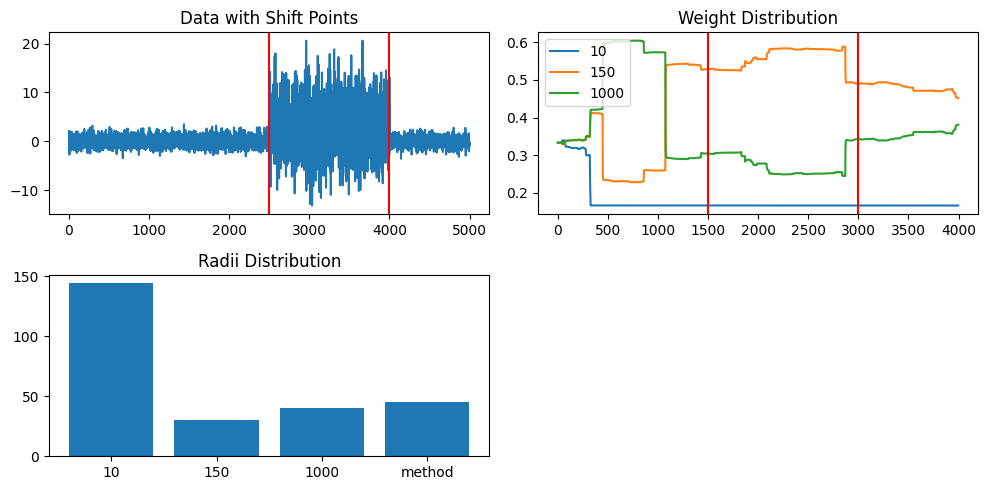

Section: 0 ----------------------------------------------------------------------------------------------------
1500


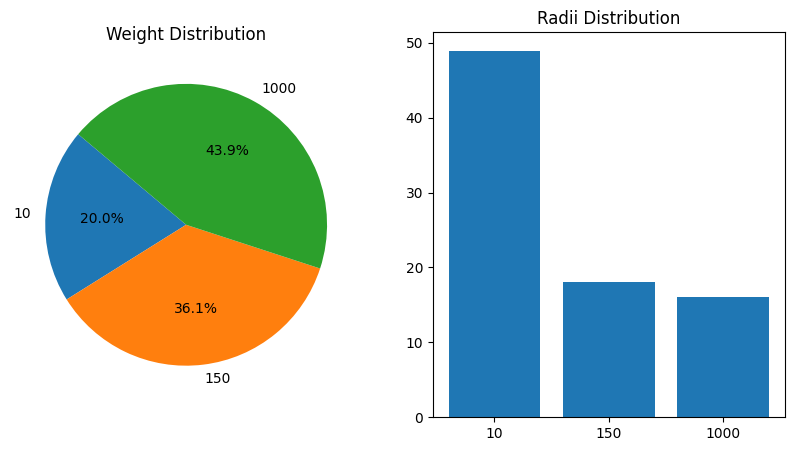

Section: 1 ----------------------------------------------------------------------------------------------------
1500


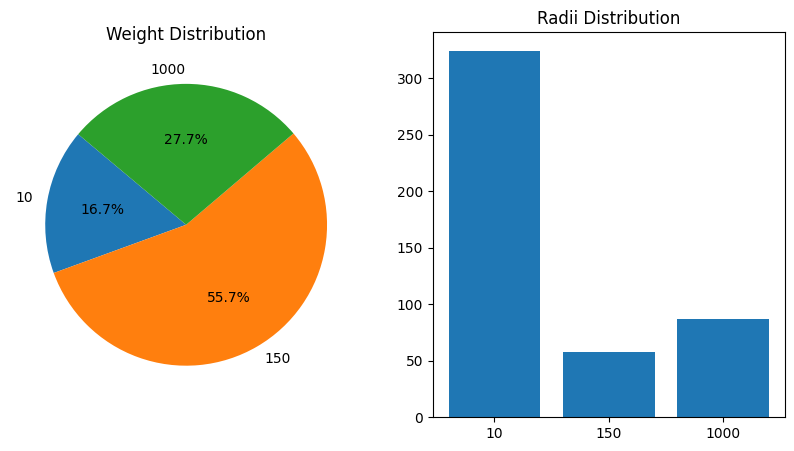

Section: 2 ----------------------------------------------------------------------------------------------------
998


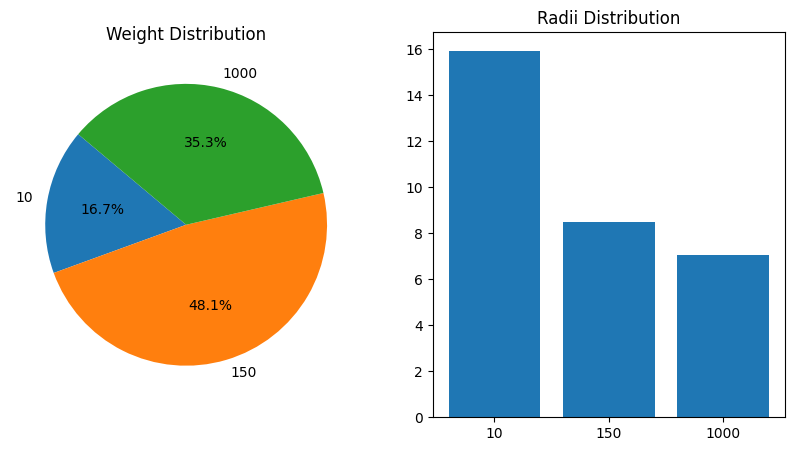

In [359]:
analyse_shifts(shift_data[0], set_safe_AwACI().AwACI, [10, 150, 1000], [int(length*x) for x in shift_points], (5*10**-4, 0.5))

Seems to perform best when doesnt over assign to a head hence the deviartion is quite small around (-4, 0.6)

['10', '150', '1000', 'method']
[143.97199102  30.50557627  40.28287787] 75.77842205602305


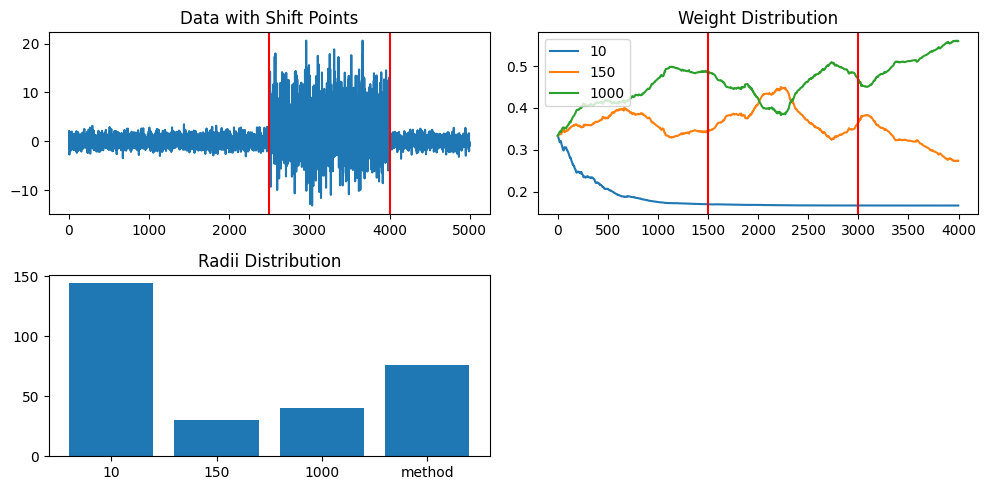

Section: 0 ----------------------------------------------------------------------------------------------------
1500


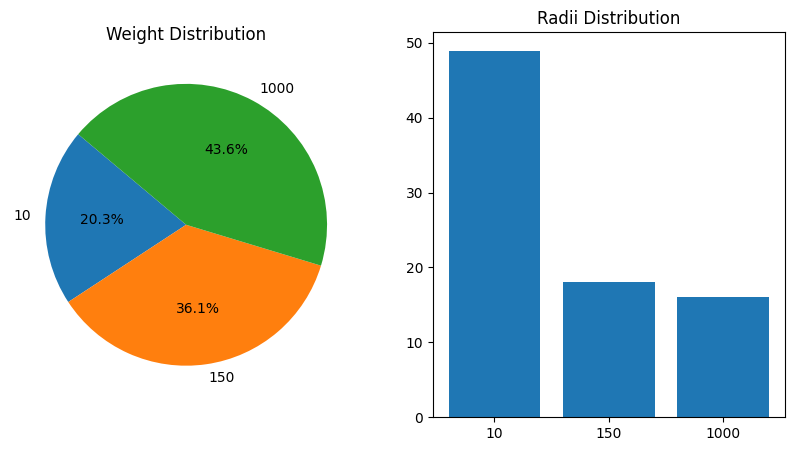

Section: 1 ----------------------------------------------------------------------------------------------------
1500


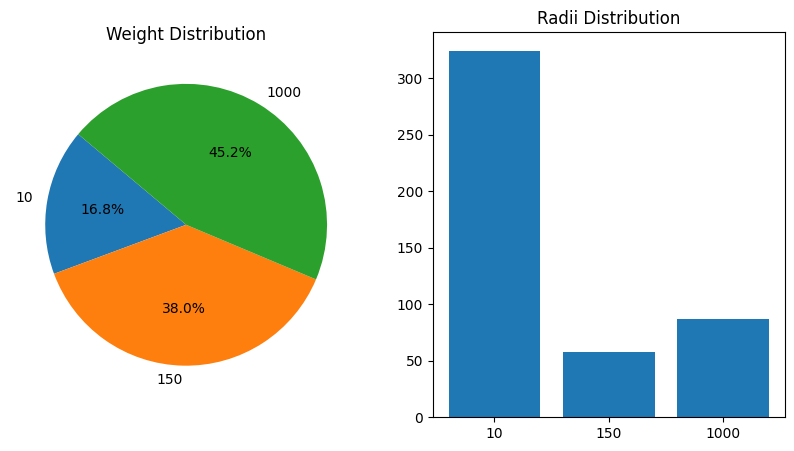

Section: 2 ----------------------------------------------------------------------------------------------------
998


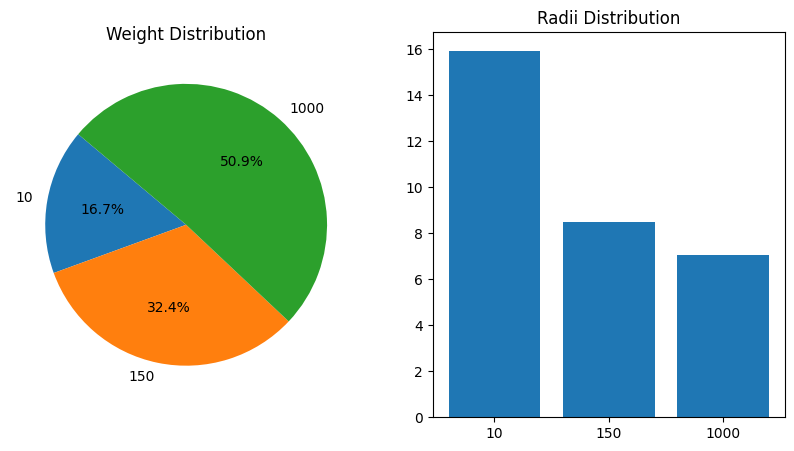

In [361]:
analyse_shifts(shift_data[0], pinball_safe_AwACI().AwACI, [10, 150, 1000], [int(length*x) for x in shift_points], (10**-0.5, 0.5))

Pinball seems to learn what you would expect it to but it doesnt perform better then set loss, which chooses a head and sticks with it more. This will likely be a result of the low set loss not nesceceraly meaning a low prediction interval on average.

If you throw in a very unperformant head then it will affect the success as if it is able to delete the head then it over optimises too quickly. Hence a method which adds a new head in when one is underweighted would have a good chance of success.

['10', '150', '1000', 'method']
[143.97199102  30.50557627  40.28287787] 54.41314081887363


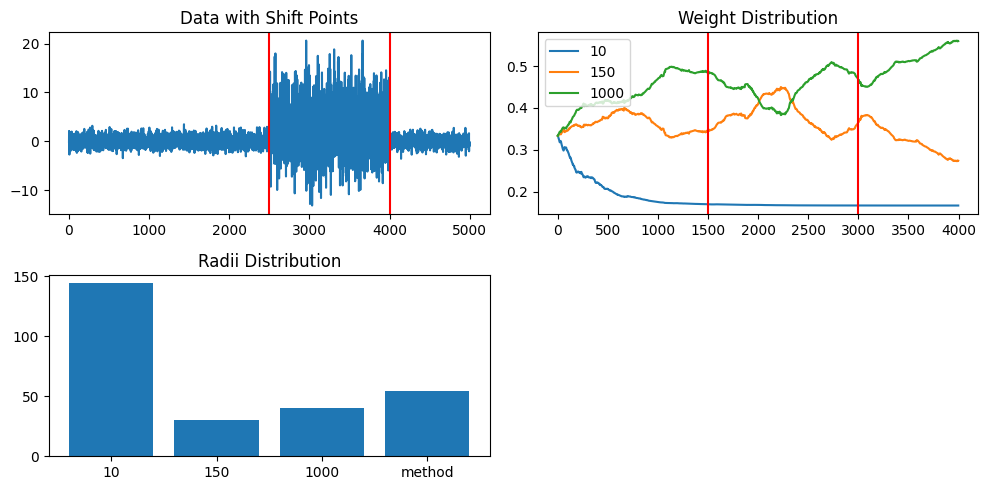

Section: 0 ----------------------------------------------------------------------------------------------------
1500


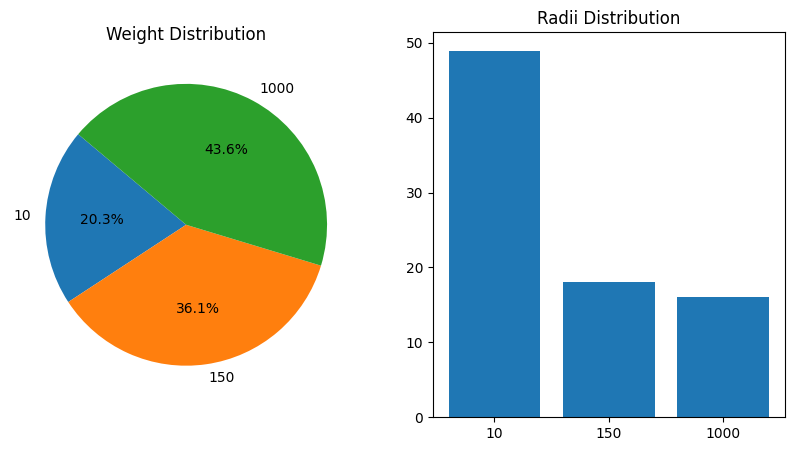

Section: 1 ----------------------------------------------------------------------------------------------------
1500


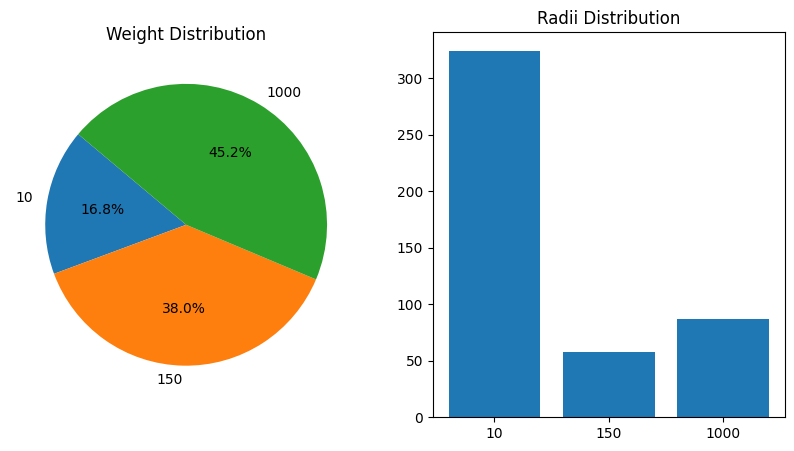

Section: 2 ----------------------------------------------------------------------------------------------------
998


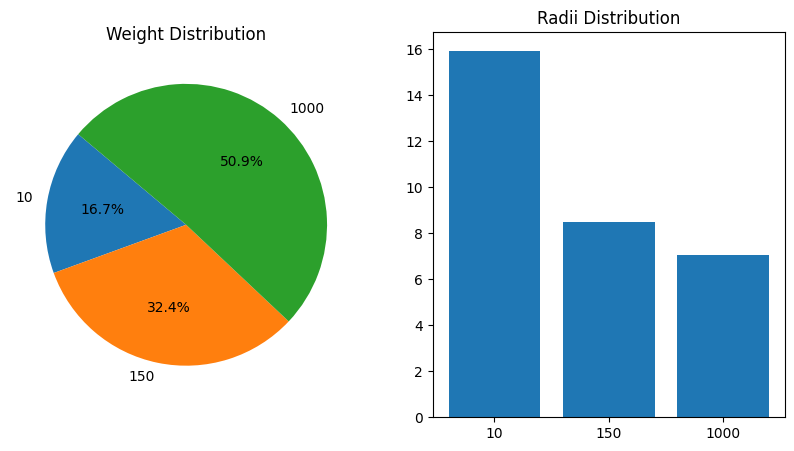

['150', '1000', 'method']
[30.50557627 40.28287787] 37.31530563324731


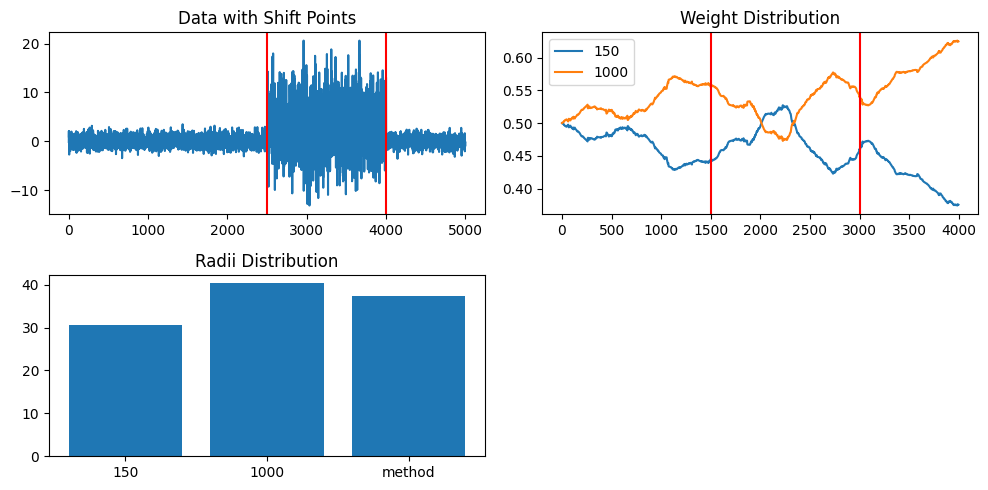

Section: 0 ----------------------------------------------------------------------------------------------------
1500


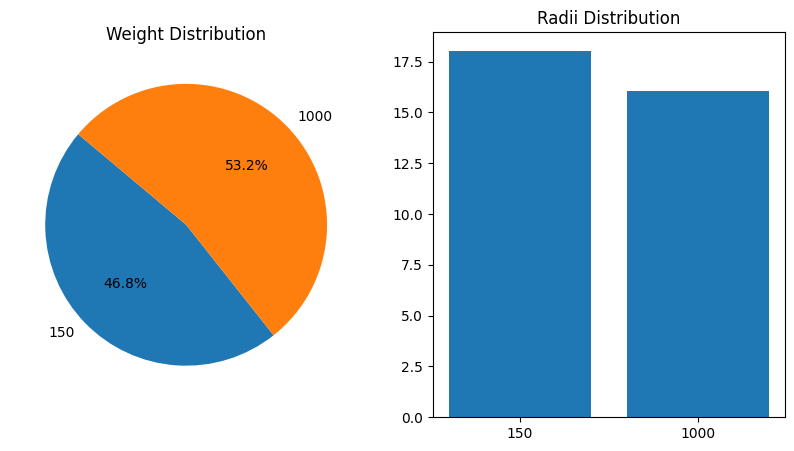

Section: 1 ----------------------------------------------------------------------------------------------------
1500


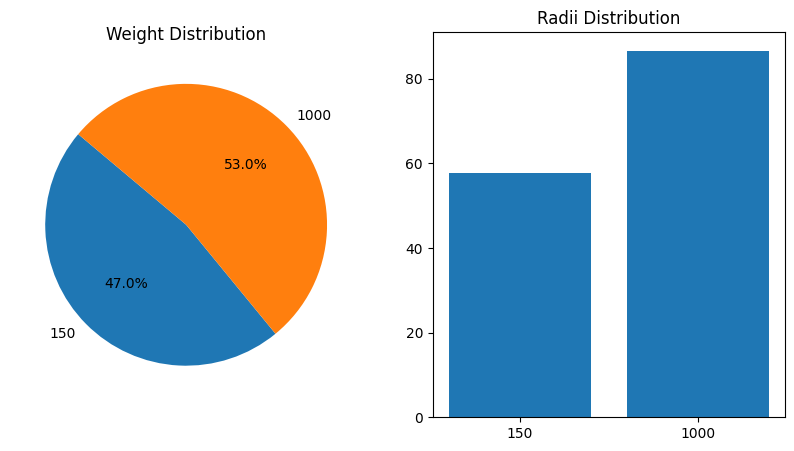

Section: 2 ----------------------------------------------------------------------------------------------------
998


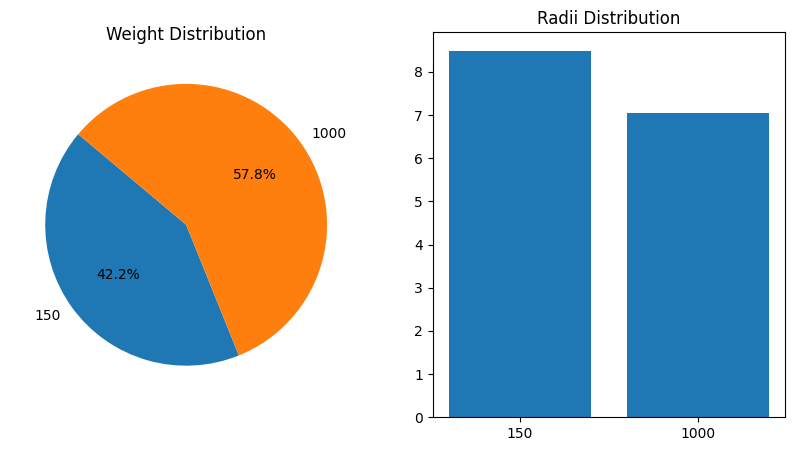

In [362]:
analyse_shifts(shift_data[0], pinball_safe_AwACI().AwACI, [10, 150, 1000], [int(length*x) for x in shift_points], (10**-0.5, 0.5))
analyse_shifts(shift_data[0], pinball_safe_AwACI().AwACI, [150, 1000], [int(length*x) for x in shift_points], (10**-0.5, 0.5))

['150', '250', '350', '450', 'method']
[32.64187384 28.6695523  48.74493312 65.4918437 ] 40.80228360783608


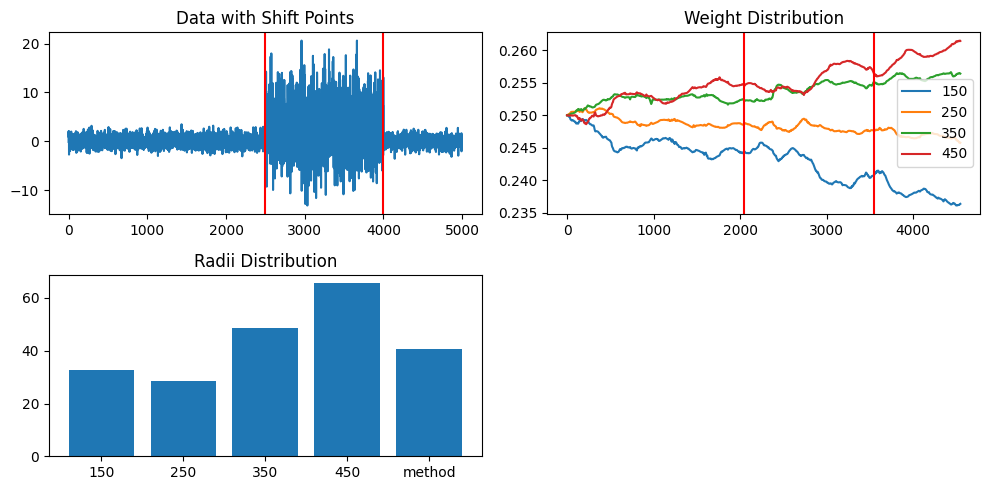

Section: 0 ----------------------------------------------------------------------------------------------------
2050


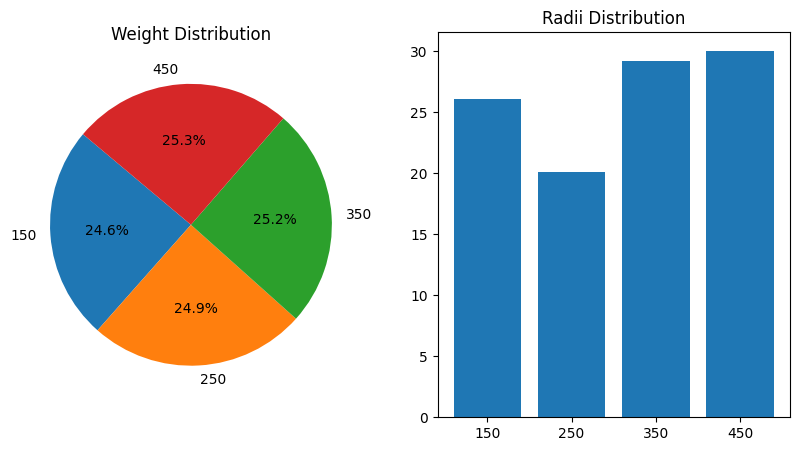

Section: 1 ----------------------------------------------------------------------------------------------------
1500


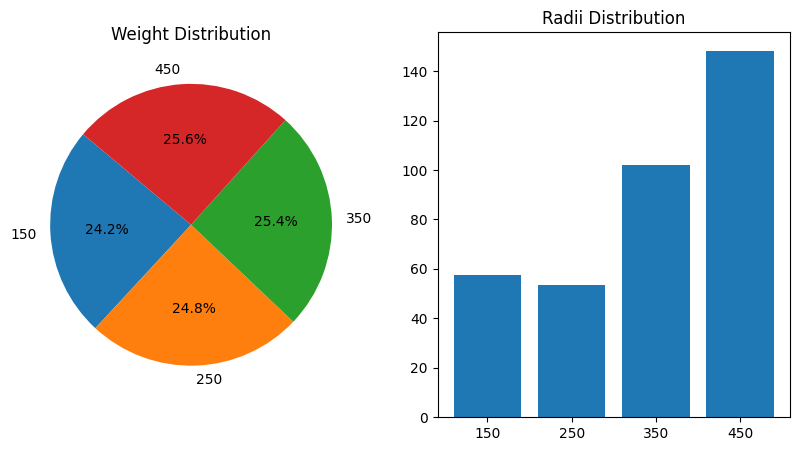

Section: 2 ----------------------------------------------------------------------------------------------------
998


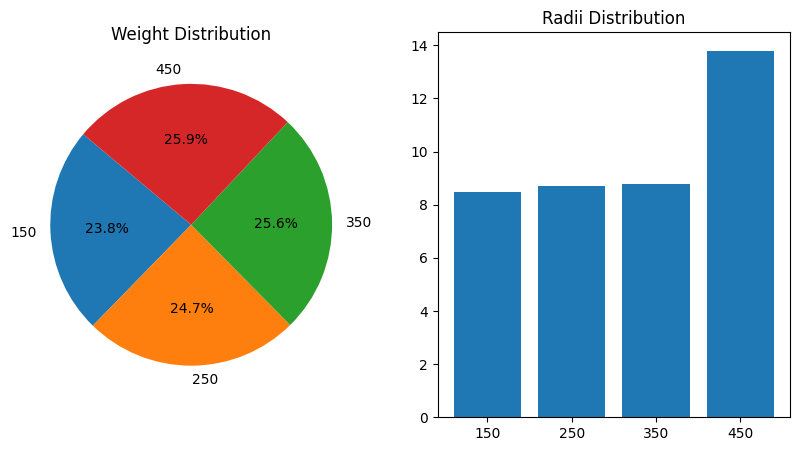

In [365]:
analyse_shifts(shift_data[0], pinball_safe_AwACI().AwACI, [150, 250, 350, 450], [int(length*x) for x in shift_points], (10**-2, 0.2))

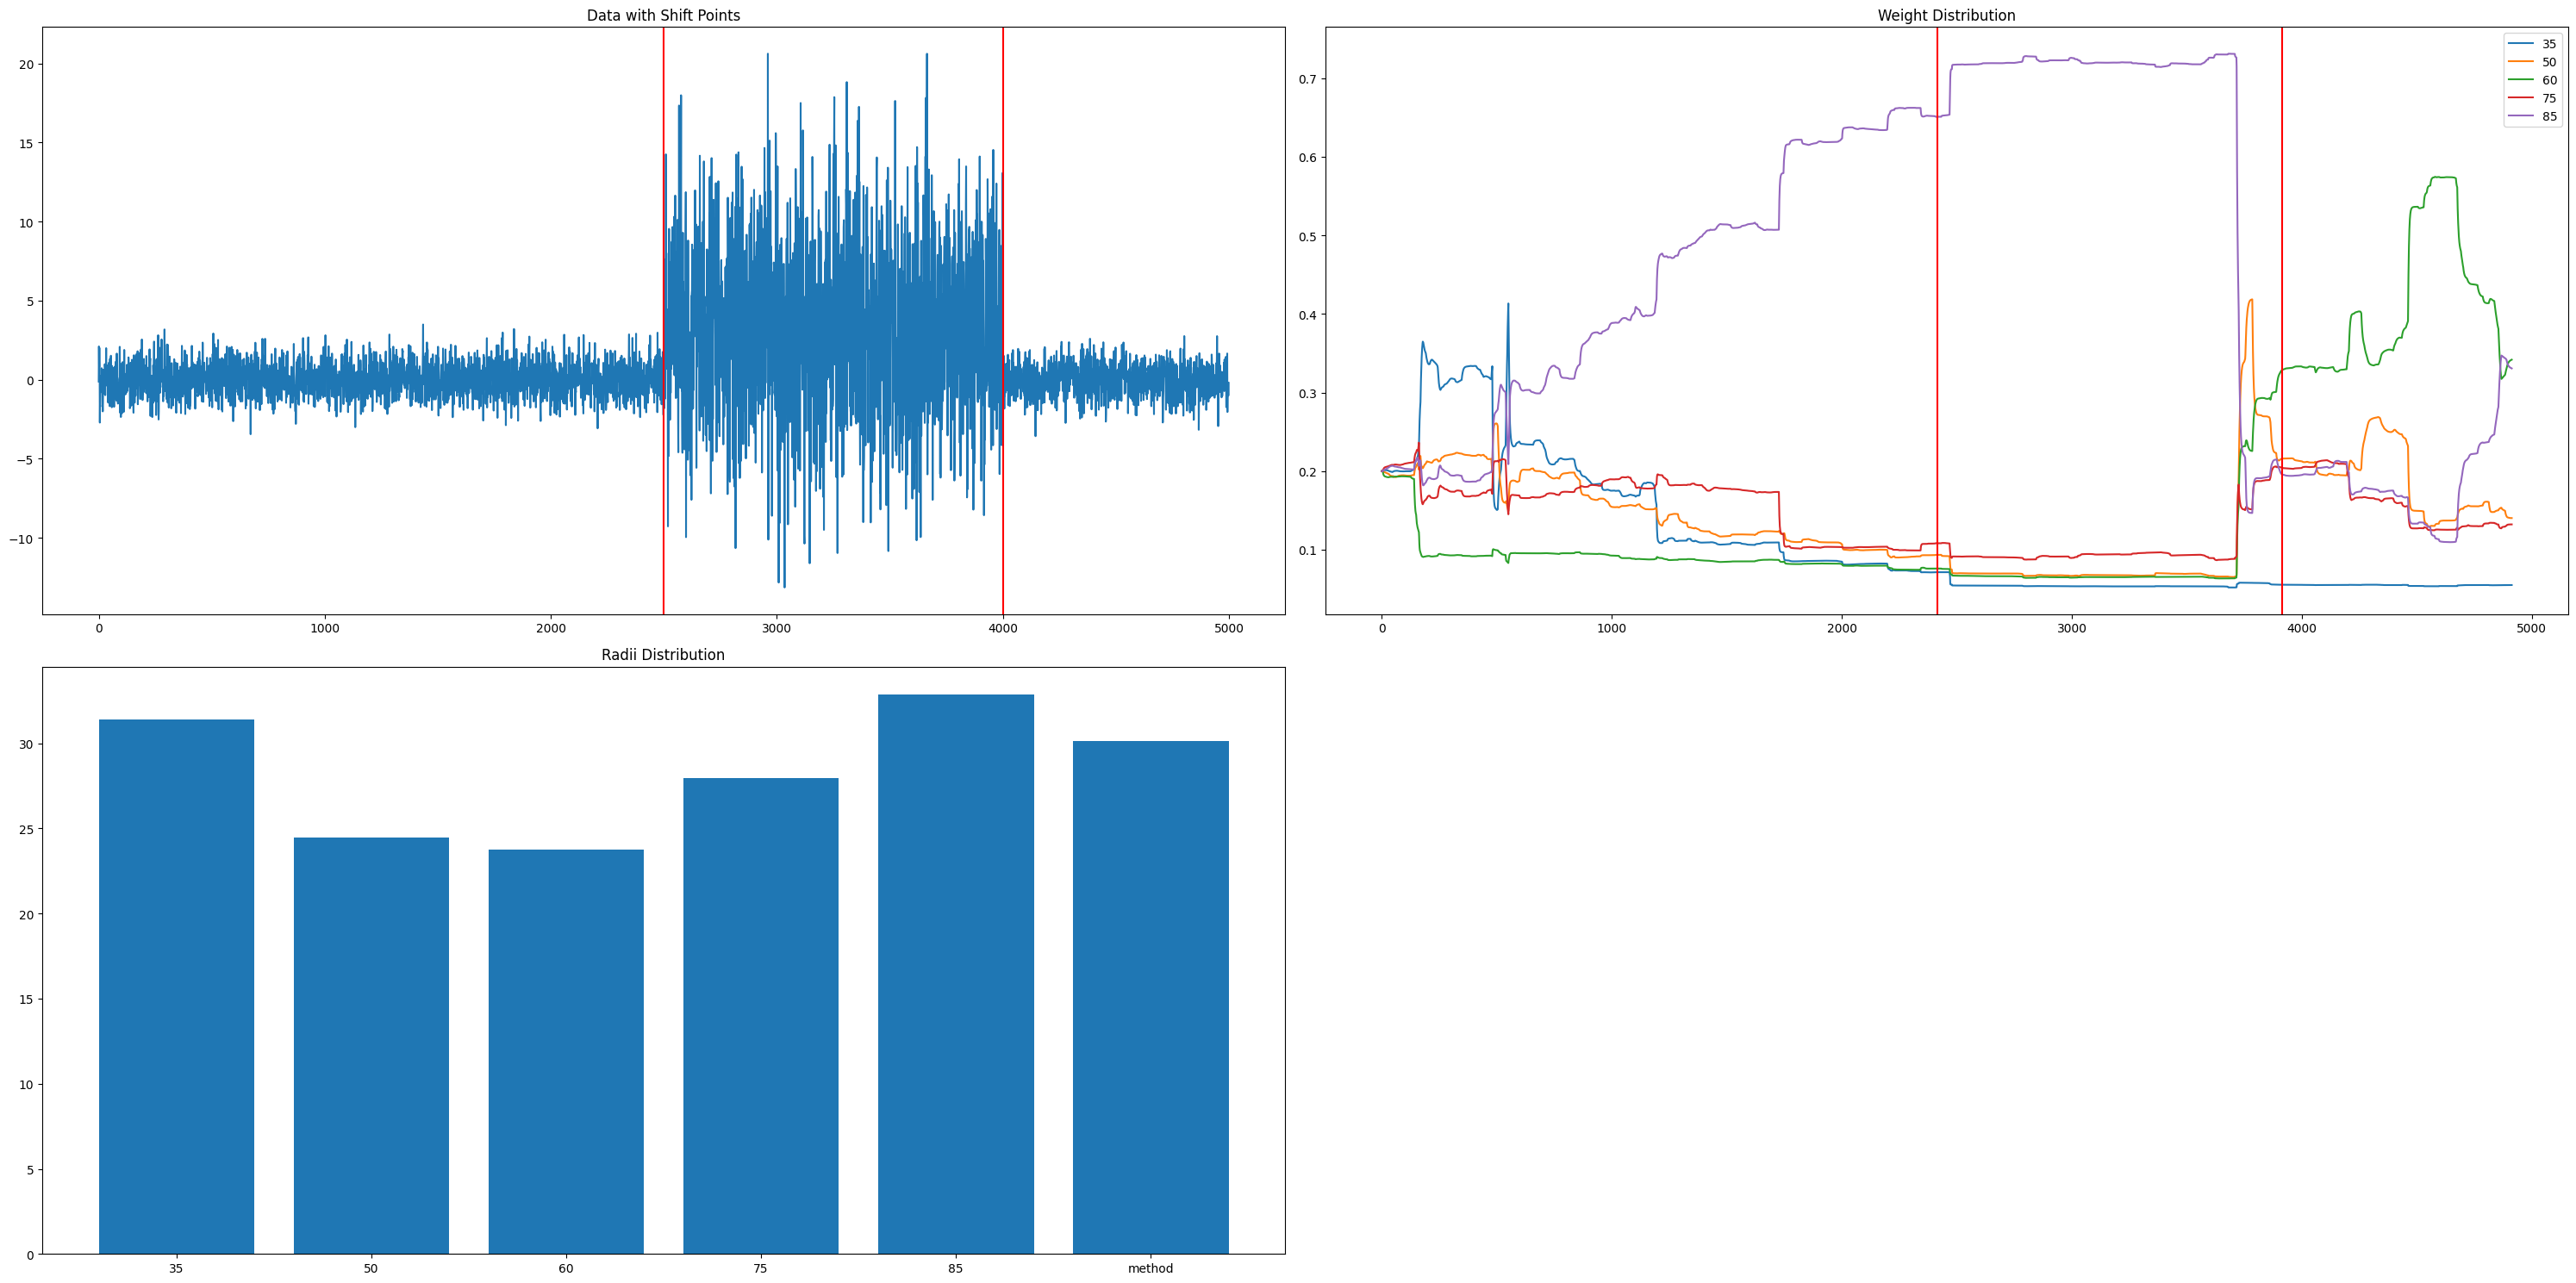

Section: 0 ----------------------------------------------------------------------------------------------------
2415


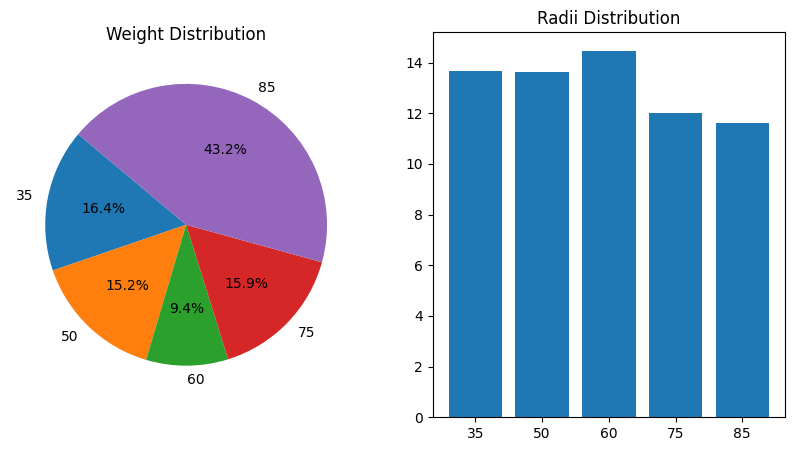

Section: 1 ----------------------------------------------------------------------------------------------------
1500


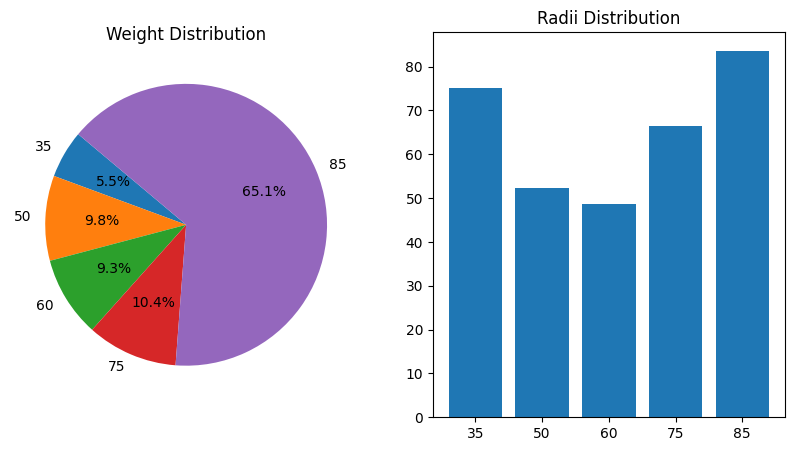

Section: 2 ----------------------------------------------------------------------------------------------------
998


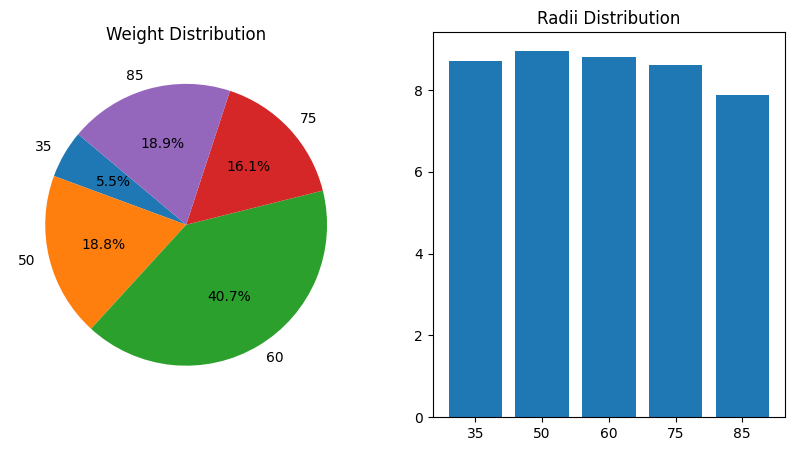

In [386]:
analyse_shifts(shift_data[0], set_safe_AwACI().AwACI, [35, 50, 60, 75, 85], [int(length*x) for x in shift_points], (10**-3, 0.25))

In [387]:
def many_analyse_shifts(data, method, candidates, shift_list, nu_sigma=(10**-2, 0.05)):
  
    result = method(data, interval_candidates=candidates, nu_sigma=nu_sigma)
    interval_candidates = result['interval_candidates']

    plt.figure(figsize=(30, 15))
    plt.subplot(2, 2, 1)
    plt.plot(data[0])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.title('Data with Shift Points')

    shift_list = [x - max(interval_candidates) for x in shift_list]
    plt.subplot(2, 2, 2)
    rel_weights = np.column_stack(result['all_weights'])
    for i, x in enumerate(rel_weights):
        plt.plot(x, label=interval_candidates[i])
    for shift in shift_list:
        plt.axvline(x=shift, color='red')
    plt.legend()
    plt.title('Weight Distribution')

    all_weights_splits = np.split(result['all_weights'], shift_list)
    all_radii_splits = np.split(result['radii_list'], shift_list)

    len_labels = [str(x) for x in interval_candidates]

    list_weight_dstack = [np.dstack(x) for x in all_weights_splits]
    list_mean_weight = [x.mean(axis=2).mean(axis=0) for x in list_weight_dstack]

    list_radii_dstack = [np.dstack(x) for x in all_radii_splits]
    list_mean_radii = [x.mean(axis=2).mean(axis=0) for x in list_radii_dstack]

    plt.subplot(2, 2, 3)
    plt.bar([str(x) for x in interval_candidates] + ['method'] , np.append(np.column_stack(result['radii_list']).mean(axis=1), result['average_prediction_interval']))
    plt.title('Radii Distribution')

    plt.tight_layout()
    plt.show()


    for i, (weight, radii) in enumerate(zip(list_mean_weight, list_mean_radii)):
        print('Section:', i, '-'*100)
        print(len(all_weights_splits[i]))
        
        # rel_weights =  np.column_stack(all_weights_splits[i])
        # for i, x in enumerate(rel_weights):
        #     plt.plot(x, label=interval_candidates[i])
        # plt.legend()
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].pie(weight, labels=len_labels, autopct='%1.1f%%', startangle=140)
        axs[0].set_title('Weight Distribution')

        axs[1].bar(len_labels, radii)
        axs[1].set_title('Radii Distribution')

        plt.show()


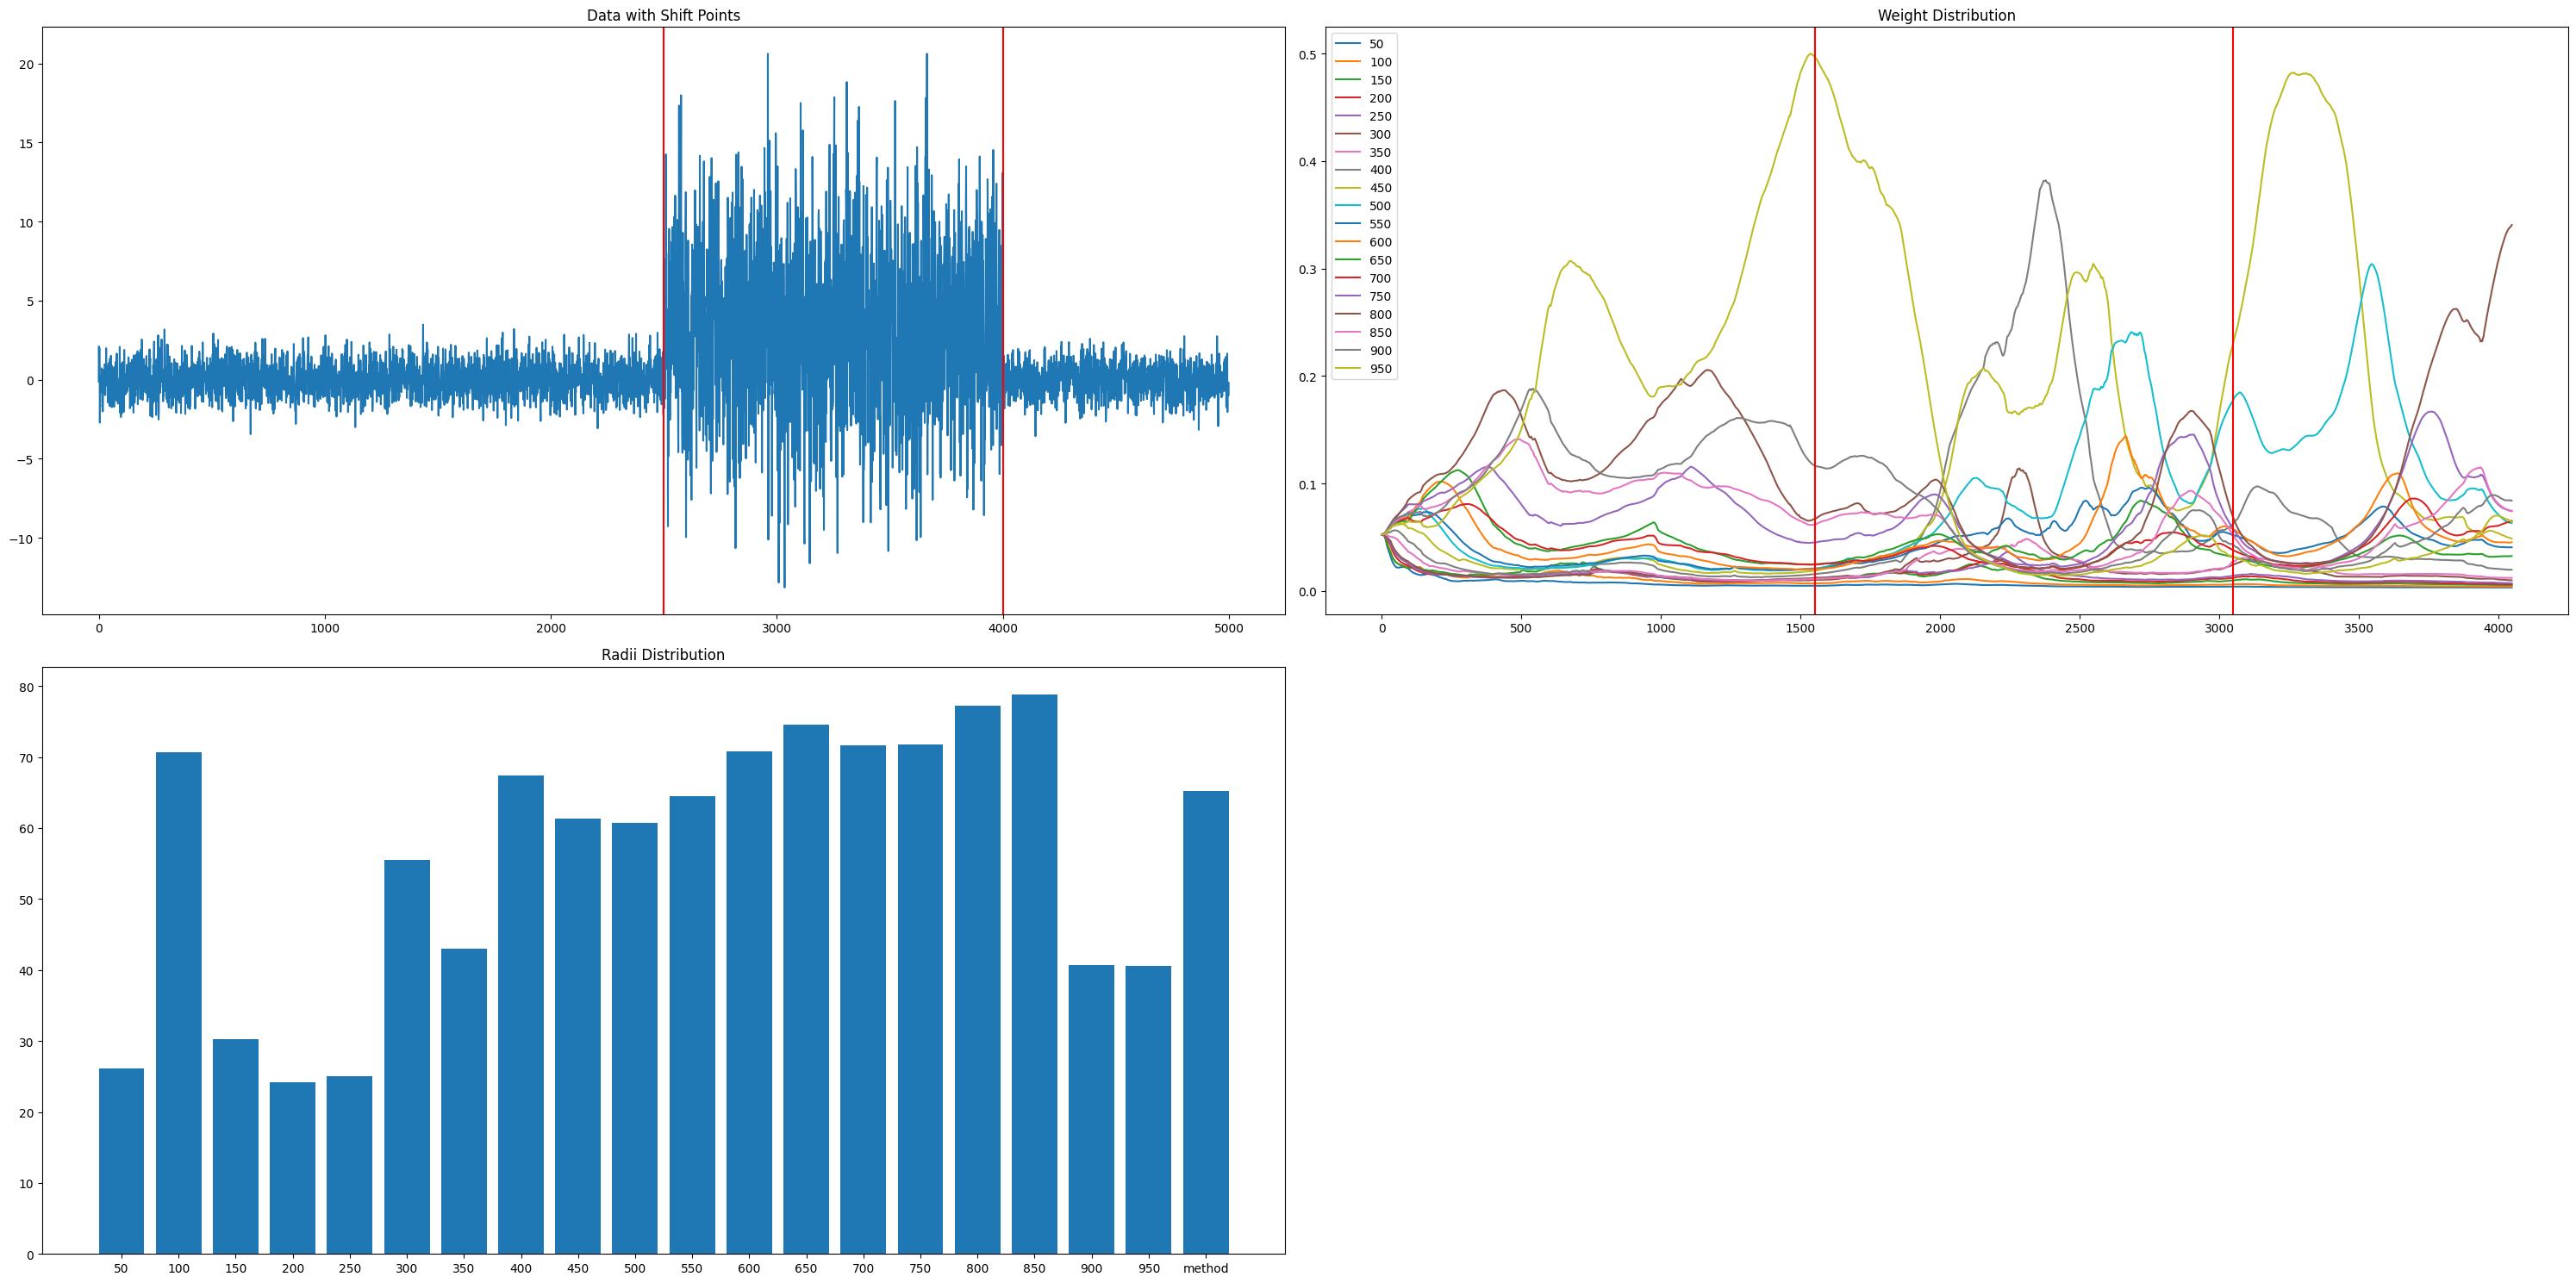

Section: 0 ----------------------------------------------------------------------------------------------------
1550


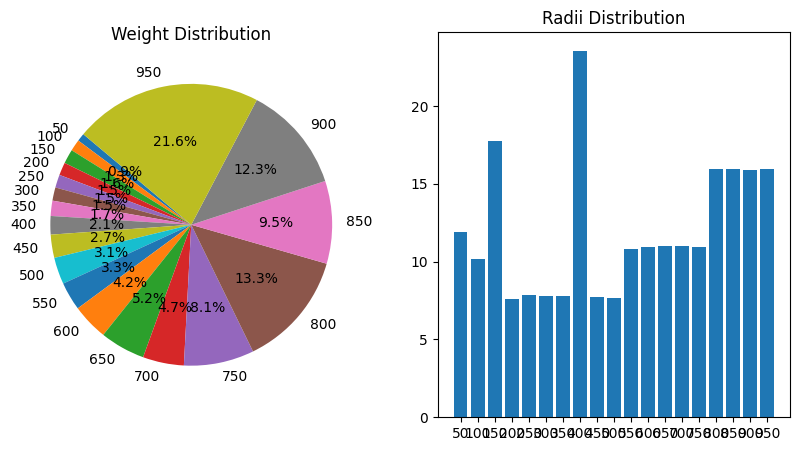

Section: 1 ----------------------------------------------------------------------------------------------------
1500


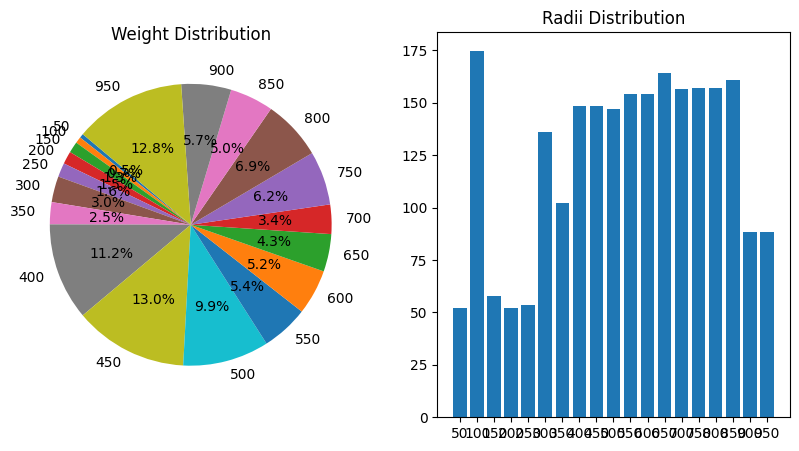

Section: 2 ----------------------------------------------------------------------------------------------------
998


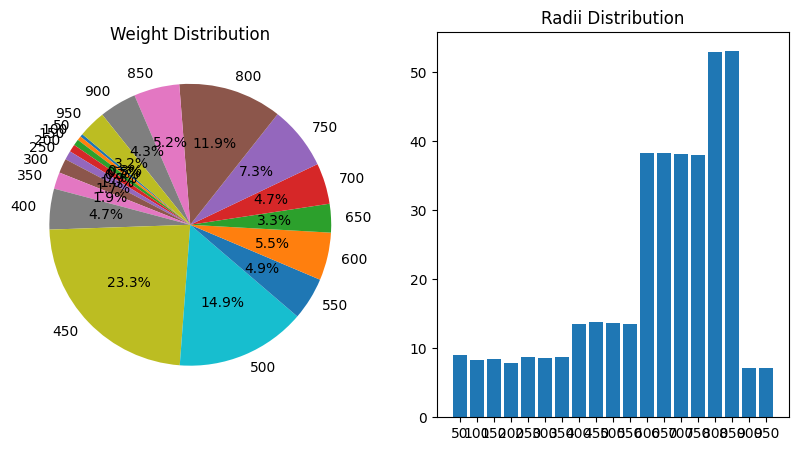

In [395]:
many_analyse_shifts(shift_data[0], pinball_safe_AwACI().AwACI, [*range(50, 1000, 50)], [int(length*x) for x in shift_points], (3*(10**-1), 0.05))